## IMDB Dataset of 50K Movie Reviews sentiment analysis

## Table of Contents
* [Introduction](#introduction)
* [Exploratory Data Analysis](#eda)
* [Machine Learning](#ml)
* [Conclusion](#conclusion)

### **Introduction**<a name="introduction"></a>

This project focuses on **Natural Language Processing (NLP)** tasks, specifically **Sentiment Analysis**. The goal is to build a machine learning model capable of interpreting the underlying sentiment of a movie review as either **positive** or **negative**.

### 📊 The Dataset
We are utilizing the **IMDB Dataset of 50K Movie Reviews**, a standard benchmark dataset for binary sentiment classification.

* **Volume:** 50,000 movie reviews.
* **Structure:** The dataset is evenly balanced with 25,000 positive and 25,000 negative reviews.
* **Source:** Kaggle ([Lakshmi Nath](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)).

In [ ]:
import os
import warnings
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.text_processing import clean_text, load_spacy_model, process_text_data, plot_pos_distribution, plot_word_clouds
from utils.train_test_pipeline import train_and_evaluate


warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
pd.set_option('display.max_colwidth', 150)
%matplotlib inline

In [2]:
# 1. Authenticate
api = KaggleApi()
api.authenticate()

# 2. Define the dataset and path
# The dataset handle is: 'lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'
dataset_handle = "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"
download_path = "./data"

# 3. Download and Unzip
# unzip=True automatically extracts the CSV from the zip file
print(f"Downloading {dataset_handle}...")
api.dataset_download_files(dataset_handle, path=download_path, unzip=True)
print("Download complete.")

# 4. Load into Pandas (Verification)
csv_file = os.path.join(download_path, "IMDB Dataset.csv")
df = pd.read_csv(csv_file)

print(f"\nData Shape: {df.shape}")
print(df.head())

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
Download complete.

Data Shape: (50000, 2)
                                                                                                                                                  review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened ...   
1  A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometim...   
2  I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted ...   
3  Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />Thi...   
4  Petter Mattei's "Love in the Time of Money" is a visually stunning film to watc

###  **Exploratory data analysis**<a name="eda"></a>

### Basic information about dataset

--- 1. Dataset Overview ---
Shape: (50000, 2)

Data Types & Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

--- Missing & Duplicate Values ---
Missing values:
review       0
sentiment    0
dtype: int64
Duplicate rows: 418
Duplicates dropped. New shape: (49582, 2)


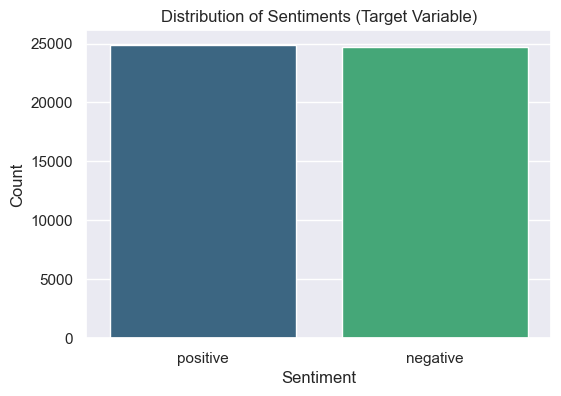


--- Review Length Statistics ---
count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: word_count, dtype: float64


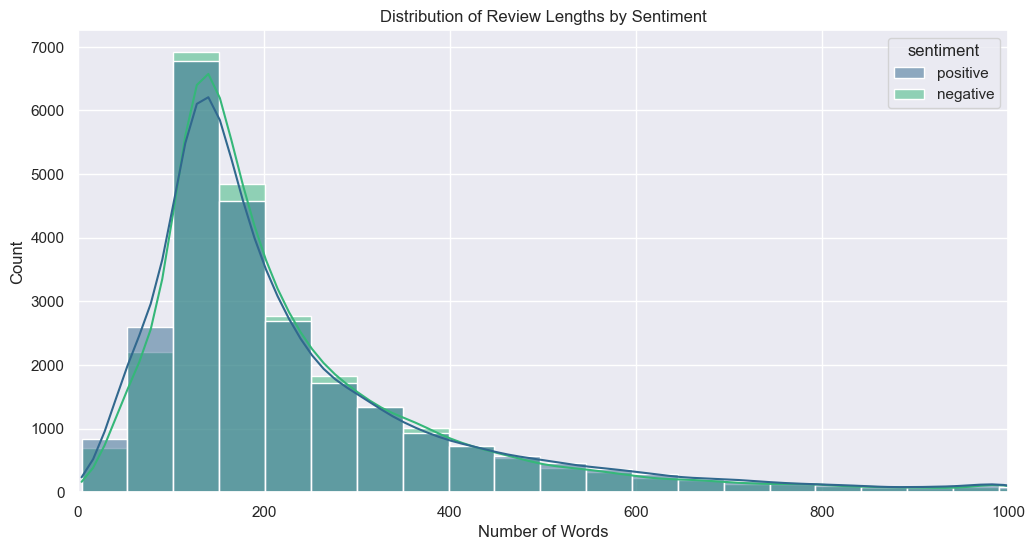

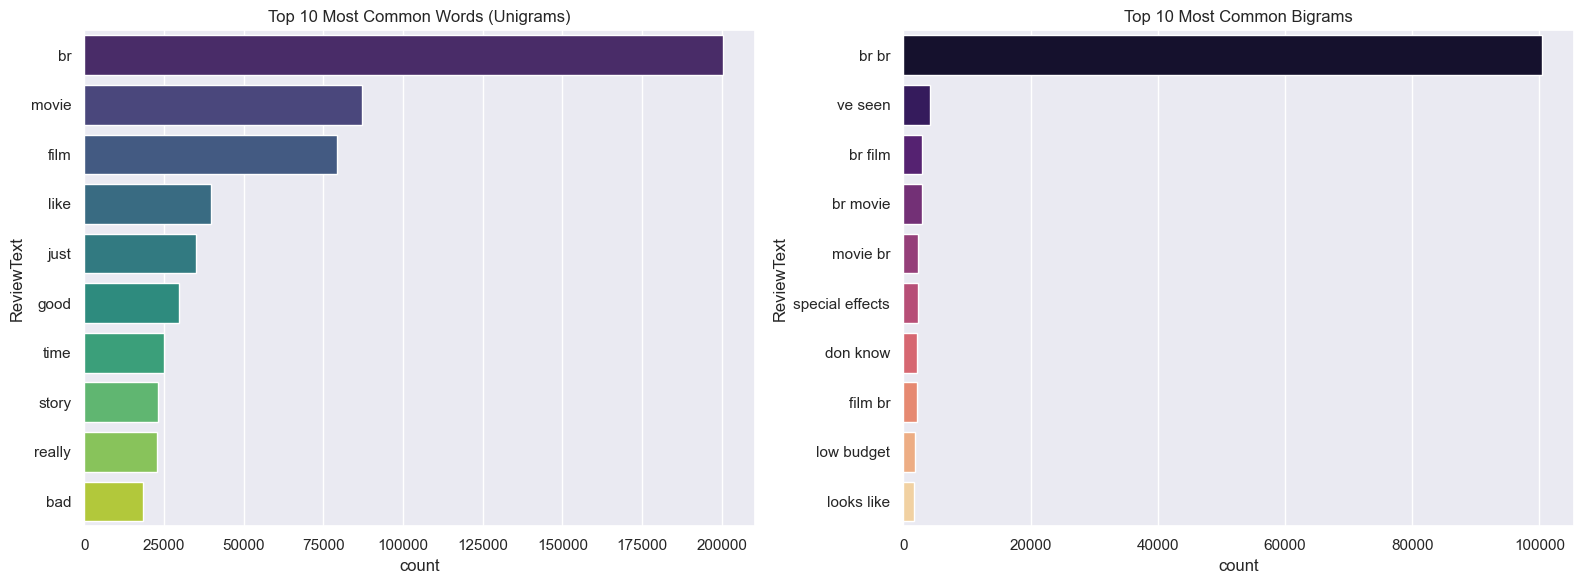

In [3]:
# ==========================================
# PART 1: Basic Data Inspection
# ==========================================
print("--- 1. Dataset Overview ---")
print(f"Shape: {df.shape}")
print("\nData Types & Info:")
print(df.info())

print("\n--- Missing & Duplicate Values ---")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Drop duplicates if any (IMDB dataset often has some)
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates dropped. New shape: {df.shape}")

# ==========================================
# PART 2: Class Distribution
# ==========================================
plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment", data=df, palette="viridis")
plt.title("Distribution of Sentiments (Target Variable)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# ==========================================
# PART 3: Review Length Analysis
# ==========================================
# Calculate word count for each review
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))

print("\n--- Review Length Statistics ---")
print(df["word_count"].describe())

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df, x="word_count", hue="sentiment", kde=True, bins=50, palette="viridis"
)
plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Number of Words")
plt.xlim(0, 1000)  # Limit x-axis to zoom in on the bulk of data
plt.show()


# ==========================================
# PART 4: Most Common Words (N-grams)
# ==========================================
def get_top_n_words(corpus, n=None, ngram_range=(1, 1)):
    """
    List the top n words in a vocabulary according to occurrence.
    """
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


# Get top 10 unigrams (single words)
common_words = get_top_n_words(df["review"], 10, (1, 1))
df1 = pd.DataFrame(common_words, columns=["ReviewText", "count"])

# Get top 10 bigrams (pairs of words)
common_bigrams = get_top_n_words(df["review"], 10, (2, 2))
df2 = pd.DataFrame(common_bigrams, columns=["ReviewText", "count"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df1, y="ReviewText", x="count", ax=axes[0], palette="viridis")
axes[0].set_title("Top 10 Most Common Words (Unigrams)")

sns.barplot(data=df2, y="ReviewText", x="count", ax=axes[1], palette="magma")
axes[1].set_title("Top 10 Most Common Bigrams")

plt.tight_layout()
plt.show()

### Data pre-processing

In [4]:
df["cleaned_review"] = df["review"].apply(lambda x: clean_text(x))

In [5]:
df.head()

,review,sentiment,word_count,cleaned_review
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened ...",positive,307,one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right wo...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometim...",positive,162,wonderful little production filming technique unassuming old-time-bbc fashion gives comforting sometimes discomforting sense realism entire piece ...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted ...",positive,166,thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light-hearted comedy plot simplistic dialogue witty c...
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />Thi...,negative,138,basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. Thi...",positive,230,petter mattei love time money visually stunning film watch mr mattei offers us vivid portrait human relations movie seems telling us money power s...


In [ ]:
df = df.drop(columns=["review", "word_count"])
df = df.rename(
    columns={"cleaned_review": "review"},
)
df.to_parquet(os.path.join(download_path, "IMDB_Cleaned.parquet"), index=False)

In [15]:
df

,sentiment,review
0,positive,one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right wo...
1,positive,wonderful little production filming technique unassuming old-time-bbc fashion gives comforting sometimes discomforting sense realism entire piece ...
2,positive,thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light-hearted comedy plot simplistic dialogue witty c...
3,negative,basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie...
4,positive,petter mattei love time money visually stunning film watch mr mattei offers us vivid portrait human relations movie seems telling us money power s...
...,...,...
49995,positive,thought movie right good job not creative_NOT original_NOT first_NOT expecting whole lotta fun think like comes dvd going pay money proudly every ...
49996,negative,bad plot bad dialogue bad acting idiotic directing annoying porn groove soundtrack ran continually overacted script crappy copy vhs not redeemed_N...
49997,negative,catholic taught parochial elementary schools nuns taught jesuit priests high school college still practicing catholic would not considered_NOT goo...
49998,negative,going disagree previous comment side maltin one second rate excessively vicious western creaks groans trying put across central theme wild west ta...


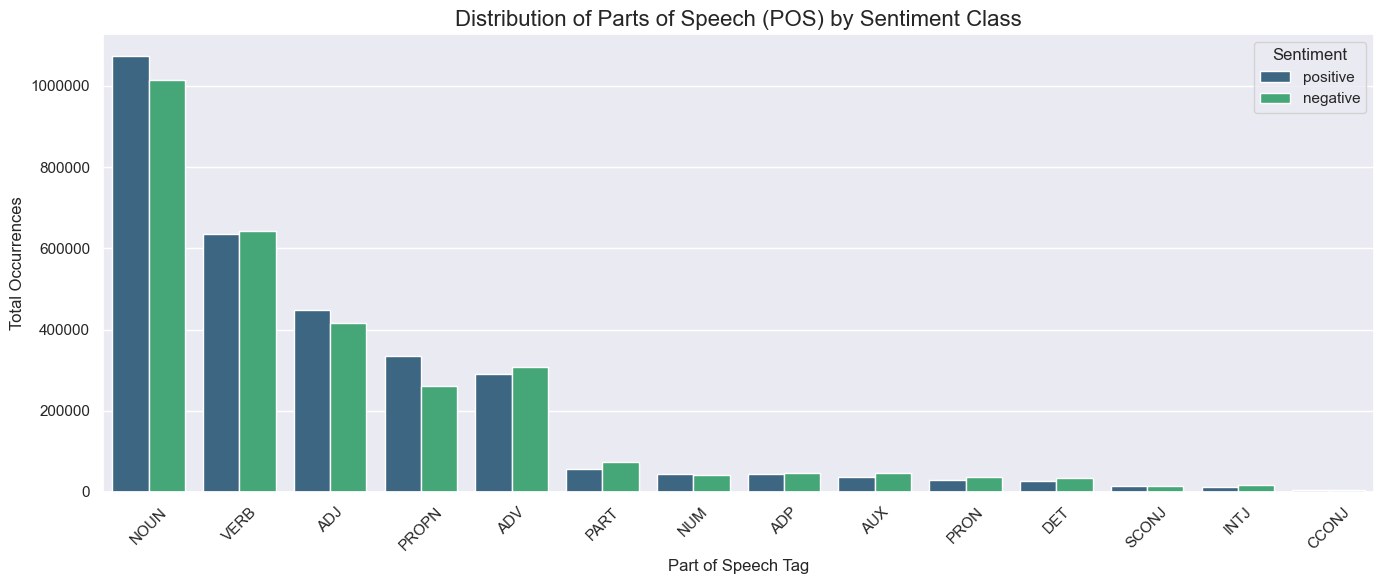

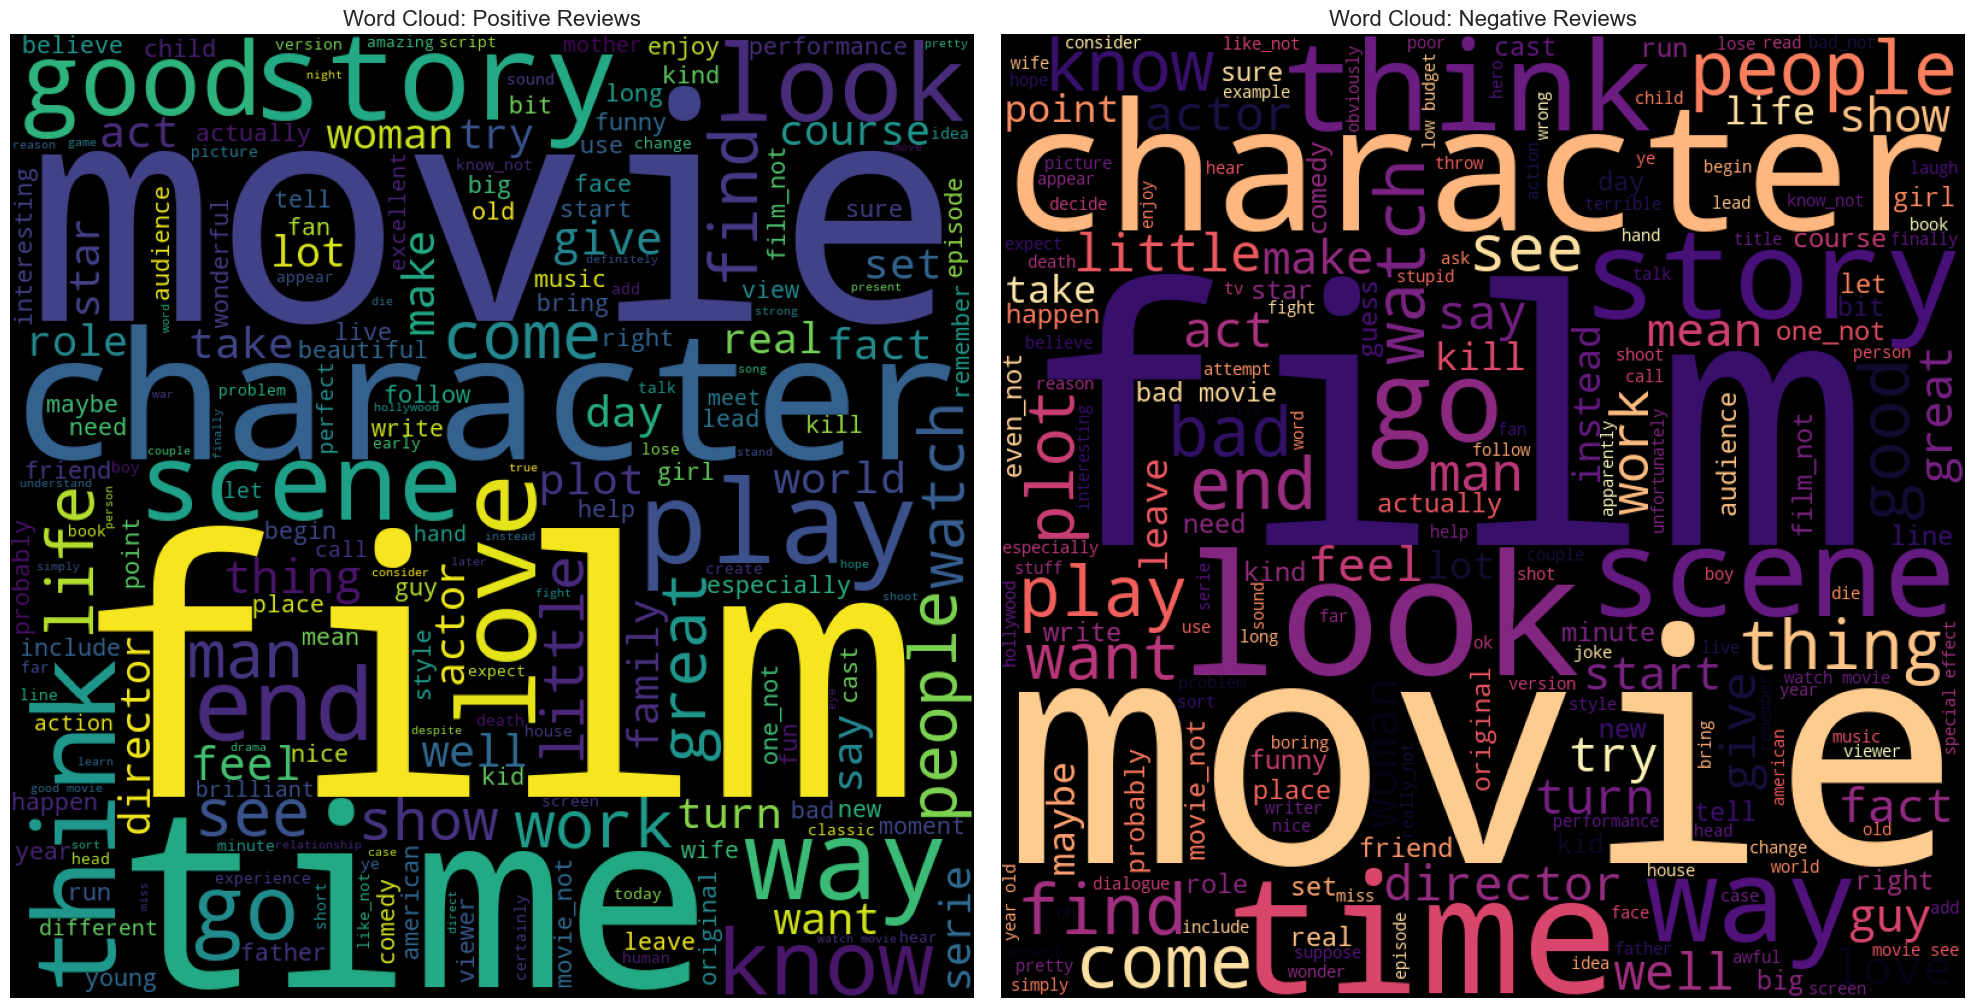

In [ ]:
df_processed = process_text_data(df, text_col="review", class_col="sentiment")
plot_pos_distribution(df_processed, class_col="sentiment")
plot_word_clouds(df_processed, class_col="sentiment")

In [24]:
df_processed

,sentiment,review,pos_counts,lemmas
0,positive,one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right wo...,"{'NUM': 1, 'NOUN': 56, 'VERB': 45, 'ADP': 3, 'ADV': 12, 'ADJ': 21, 'PART': 6, 'PRON': 1, 'AUX': 5, 'DET': 3, 'PROPN': 12, 'CCONJ': 1}",reviewer mention watch oz episode hook right exactly happen thing strike oz brutality unflinche scene violence set right word trust show_not faint...
1,positive,wonderful little production filming technique unassuming old-time-bbc fashion gives comforting sometimes discomforting sense realism entire piece ...,"{'ADJ': 14, 'NOUN': 30, 'VERB': 19, 'ADV': 14, 'PROPN': 6, 'PART': 2, 'ADP': 1, 'NUM': 1, 'DET': 1}",wonderful little production filming technique unassuming old time bbc fashion give comfort discomforte sense realism entire piece actor extremely ...
2,positive,thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light-hearted comedy plot simplistic dialogue witty c...,"{'VERB': 21, 'ADJ': 16, 'NOUN': 28, 'ADV': 9, 'AUX': 3, 'PART': 2, 'PROPN': 6, 'NUM': 1}",think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character li...
3,negative,basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie...,"{'ADV': 6, 'NOUN': 25, 'ADJ': 8, 'PROPN': 7, 'VERB': 15, 'INTJ': 1, 'AUX': 1, 'ADP': 1}",basically family little boy jake think zombie closet parent fight time movie slow soap opera suddenly jake decide rambo kill zombie ok go film dec...
4,positive,petter mattei love time money visually stunning film watch mr mattei offers us vivid portrait human relations movie seems telling us money power s...,"{'NOUN': 42, 'ADV': 8, 'ADJ': 15, 'PROPN': 26, 'VERB': 25, 'PRON': 3, 'NUM': 4, 'DET': 2, 'PART': 1}",petter mattei love time money visually stunning film watch mr mattei offer vivid portrait human relation movie tell money power success people dif...
...,...,...,...,...
49995,positive,thought movie right good job not creative_NOT original_NOT first_NOT expecting whole lotta fun think like comes dvd going pay money proudly every ...,"{'NOUN': 23, 'ADV': 10, 'ADJ': 8, 'PART': 6, 'VERB': 24, 'PROPN': 4, 'ADP': 2, 'DET': 1, 'NUM': 2, 'PRON': 2, 'AUX': 1}",thought movie right good job creative_not original_not first_not expect lotta fun think like come dvd go pay money proudly cent sharon stone great...
49996,negative,bad plot bad dialogue bad acting idiotic directing annoying porn groove soundtrack ran continually overacted script crappy copy vhs not redeemed_N...,"{'ADJ': 10, 'NOUN': 25, 'VERB': 9, 'ADV': 2, 'PART': 1, 'PROPN': 6, 'AUX': 1, 'PRON': 1, 'NUM': 1, 'ADP': 1}",bad plot bad dialogue bad acting idiotic directing annoy porn groove soundtrack run continually overact script crappy copy vhs redeemed_not consum...
49997,negative,catholic taught parochial elementary schools nuns taught jesuit priests high school college still practicing catholic would not considered_NOT goo...,"{'PROPN': 11, 'VERB': 22, 'ADJ': 15, 'NOUN': 41, 'ADV': 9, 'AUX': 3, 'PART': 3, 'DET': 4, 'ADP': 1, 'NUM': 4, 'SCONJ': 1}",catholic teach parochial elementary school nun teach jesuit priest high school college practice catholic considered_not good_not catholic_not chur...
49998,negative,going disagree previous comment side maltin one second rate excessively vicious western creaks groans trying put across central theme wild west ta...,"{'VERB': 23, 'ADJ': 22, 'NOUN': 41, 'NUM': 4, 'ADV': 7, 'ADP': 2, 'PROPN': 9, 'AUX': 1, 'PRON': 2, 'PART': 2}",go disagree previous comment maltin rate excessively vicious western creak groan try central theme wild west tame kick aside steady march time lik...


In [25]:
df_processed.to_parquet(
    os.path.join(download_path, "IMDB_Processed.parquet"), index=False
)

## **Machine Learning**<a name="ml"></a>

Starting Experiment with 100 trials...


Optimizing Hyperparameters:   0%|          | 0/100 [00:00<?, ?it/s]


Best CV Score: 0.8990
Best Parameters: {'tfidf__min_df': 3, 'tfidf__max_df': 0.8735833781483985, 'clf__C': 8.46496020839478, 'clf__tol': 9.47888314747608e-05}
Retraining final model on full training set...
------------------------------
Final Test Accuracy: 0.9070

Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.90      0.91      4940
    positive       0.90      0.91      0.91      4977

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917



<Figure size 800x600 with 0 Axes>

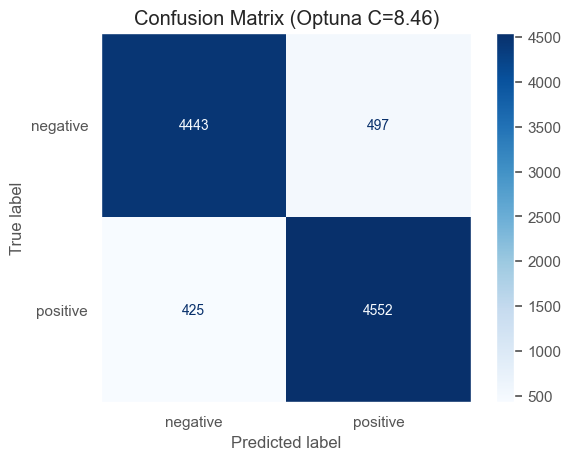

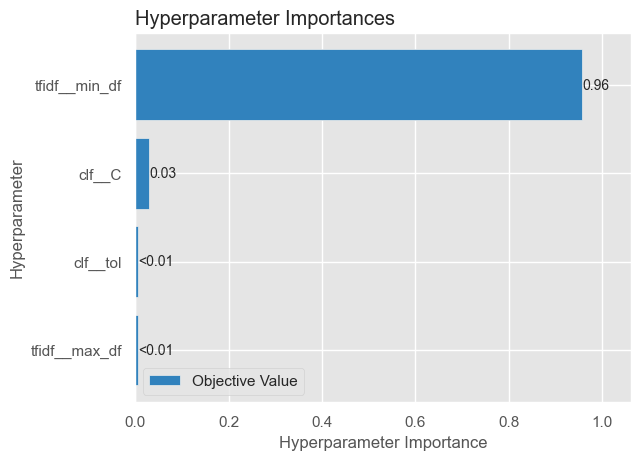

In [68]:
trained_model, metrics = train_and_evaluate(
    df_processed, text_col="lemmas", target_col="sentiment"
)